## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

2023-01-16 12:50:44.022949: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Opening JSON file 
f = open('complaints-2021-05-14_08_16.json')# Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [3]:
# Inspect the dataframe to understand the given data.
df.shape

(78313, 22)

In [4]:
#insepecting column data type of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [5]:
#looking at sample data
pd.set_option('display.max_columns', None)
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [6]:
#print the column names
df.columns


Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [7]:
#Assign new column names
new_col_list=[ re.split('\.',i)[-1] if i.find('.')!=-1 else re.split('_',i)[-1] for i in df.columns ]
df.columns=new_col_list
df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [8]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened']=df['complaint_what_happened'].apply(lambda x : np.NaN if x.strip()=='' else x)

In [9]:
#Remove all rows where complaints column is nan
df=df[~df['complaint_what_happened'].isna()]
df.shape

(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [10]:
import swifter

In [11]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(x):
    #making the test lowercase
    x=x.lower().strip()
    # removing square brackets
    x=re.sub(r'\[.*\]', '', x)
    # removing punctuation
    x = re.sub(r'[^\w\s]', '', x)
    # removing words containing numbers
    x = re.sub(r'\w*\d\w*\s', '', x)
    #removing extra spaces which are created by replacing texts above
    x = re.sub(' {2,}', ' ', x)
    return x

In [12]:
#Write your function to Lemmatize the texts

def lemmatise(x):
    word_lemmatizer=nltk.stem.WordNetLemmatizer()
#     stemmer = nltk.stem.porter.PorterStemmer()
    tokens=nltk.tokenize.word_tokenize(x)
    return ' '.join([word_lemmatizer.lemmatize(token) if token!='' else '' for token in tokens ])
#     return ' '.join([stemmer.stem(token.text) if token!='' for token in tokens ])


In [13]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean=pd.DataFrame(data=list(df['complaint_what_happened'].swifter.apply(clean_text)),columns={'Complaints'})
df_clean['lemmatized_complaints']=df_clean['Complaints'].swifter.apply(lemmatise)
df_clean

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

,Complaints,lemmatized_complaints
0,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...
1,i upgraded my xxxx xxxx card in and was told b...,i upgraded my xxxx xxxx card in and wa told by...
2,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...
3,on while trying to book a xxxx xxxx ticket i c...,on while trying to book a xxxx xxxx ticket i c...
4,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...
...,...,...
21067,after being a chase card customer for well ove...,after being a chase card customer for well ove...
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...
21069,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...
21070,i have had flawless credit for yrs ive had cha...,i have had flawless credit for yr ive had chas...


In [14]:
#Write your function to extract the POS tags 

def pos_tag(text):
  # write your code here
    tokens=nlp(text['Complaints'])            
    return ' '.join([token.text if token.tag_=='NN' else '' for token in tokens])    


df_clean["complaint_POS_removed"] =  df_clean.swifter.apply(pos_tag,axis=1)

#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].


Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [15]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head()

,Complaints,lemmatized_complaints,complaint_POS_removed
0,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop ...
1,i upgraded my xxxx xxxx card in and was told b...,i upgraded my xxxx xxxx card in and wa told by...,agent anniversary date ...
2,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,chase card application identity con...
3,on while trying to book a xxxx xxxx ticket i c...,on while trying to book a xxxx xxxx ticket i c...,ticket offer ticket ca...
4,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chas...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

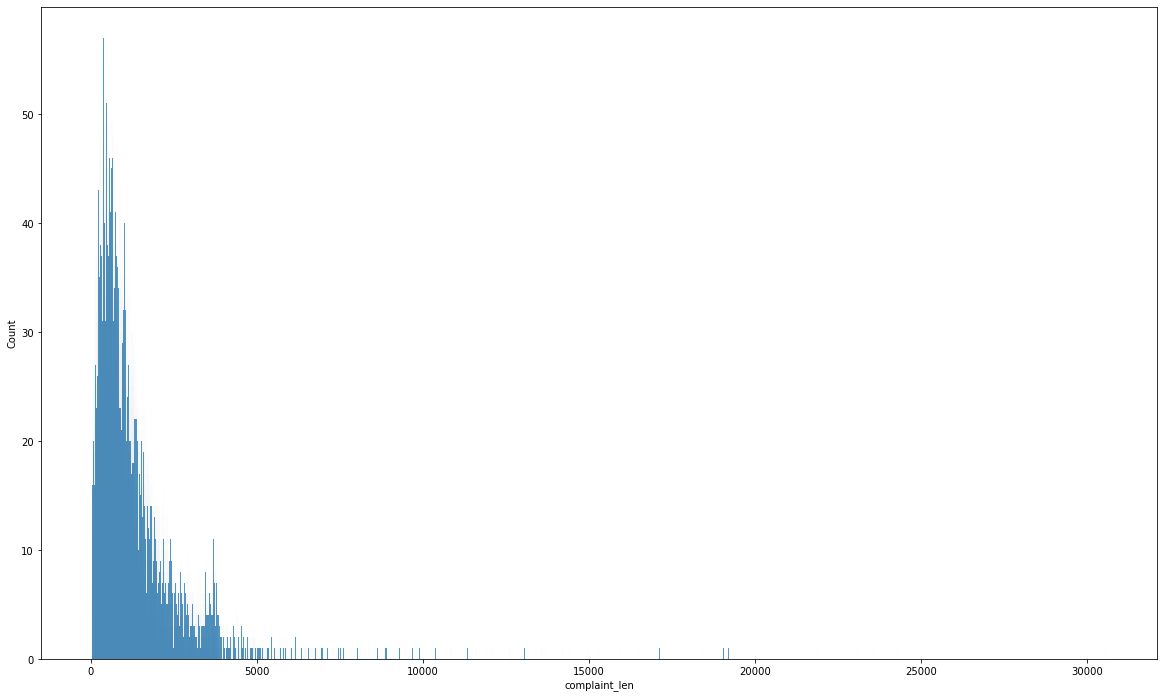

In [16]:
# Write your code here to visualise the data according to the 'Complaint' character length
df_clean['complaint_len']=df_clean['Complaints'].swifter.apply(lambda x : len(x))
plt.figure(figsize=[20,12])
sns.histplot(data=df_clean, x="complaint_len",binwidth=3,bins=50)
plt.show()


#### Find the top 40 words by frequency among all the articles after processing the text.

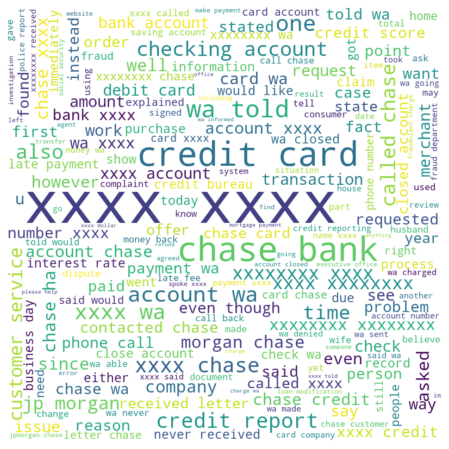

In [17]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
stop = nltk.corpus.stopwords.words('english')
word_list=[]
for sentence in df_clean['lemmatized_complaints']:
    for word in sentence.split(' '):
        if word not in stop:
            word_list.append(word)

from wordcloud import WordCloud
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stop,
                min_font_size = 10).generate(' '.join(word_list))
 
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Top 40 words are
xxxx chase wa account credit card bank xxxxxxxx payment would told time ha called charge day received money check back call loan said never letter information made could get fee transaction number also report month amount sent year mortgage customer

In [18]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [19]:
from nltk.util import ngrams

In [20]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 

def get_ngram(n):
    fdist = nltk.probability.FreqDist()
    for sentences in df_clean['Complaints']:
        ng=ngrams(sentences.lower().split(' '),n)
        for word in ng:
            if word!='':
                fdist[word] += 1
    return fdist


In [21]:
unigram=get_ngram(1)

In [22]:
#Print the top 10 words in the unigram frequency
unigram.most_common(10)

[(('the',), 236728),
 (('xxxx',), 190449),
 (('i',), 185198),
 (('to',), 181620),
 (('and',), 145284),
 (('a',), 106022),
 (('my',), 105801),
 (('that',), 86105),
 (('was',), 79713),
 (('of',), 79165)]

In [23]:
for word in ngrams('hi this is a boy'.split(' '),2):
    print(word)

('hi', 'this')
('this', 'is')
('is', 'a')
('a', 'boy')


In [24]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
bigram=get_ngram(2)
bigram.most_common(30)

[(('xxxx', 'xxxx'), 71107),
 (('i', 'was'), 19475),
 (('i', 'have'), 18189),
 (('of', 'the'), 16903),
 (('that', 'i'), 15370),
 (('to', 'the'), 13438),
 (('my', 'account'), 12451),
 (('chase', 'bank'), 12239),
 (('in', 'the'), 11750),
 (('and', 'i'), 11205),
 (('credit', 'card'), 10841),
 (('xxxx', 'and'), 10681),
 (('on', 'the'), 10603),
 (('i', 'am'), 9771),
 (('i', 'had'), 9714),
 (('my', 'credit'), 9682),
 (('for', 'the'), 9576),
 (('on', 'my'), 9346),
 (('did', 'not'), 9052),
 (('that', 'the'), 8897),
 (('on', 'xxxxxxxx'), 8893),
 (('in', 'xxxx'), 8097),
 (('xxxx', 'i'), 7954),
 (('it', 'was'), 7598),
 (('i', 'called'), 7538),
 (('to', 'my'), 7519),
 (('the', 'xxxx'), 7505),
 (('with', 'the'), 7228),
 (('to', 'be'), 7183),
 (('and', 'the'), 7160)]

In [25]:
#Print the top 10 words in the bigram frequency
bigram.most_common(10)

[(('xxxx', 'xxxx'), 71107),
 (('i', 'was'), 19475),
 (('i', 'have'), 18189),
 (('of', 'the'), 16903),
 (('that', 'i'), 15370),
 (('to', 'the'), 13438),
 (('my', 'account'), 12451),
 (('chase', 'bank'), 12239),
 (('in', 'the'), 11750),
 (('and', 'i'), 11205)]

In [26]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
bigram=get_ngram(3)
bigram.most_common(30)

[(('xxxx', 'xxxx', 'xxxx'), 29752),
 (('xxxx', 'xxxx', 'and'), 3906),
 (('i', 'did', 'not'), 3491),
 (('on', 'xxxx', 'xxxx'), 3353),
 (('i', 'was', 'told'), 3335),
 (('xxxx', 'xxxx', 'i'), 3100),
 (('xxxx', 'and', 'xxxx'), 2465),
 (('my', 'credit', 'report'), 2452),
 (('i', 'received', 'a'), 2423),
 (('i', 'have', 'been'), 2379),
 (('on', 'my', 'credit'), 2370),
 (('on', 'xxxxxxxx', 'i'), 2279),
 (('to', 'xxxx', 'xxxx'), 2250),
 (('jp', 'morgan', 'chase'), 2242),
 (('i', 'called', 'chase'), 2189),
 (('told', 'me', 'that'), 2085),
 (('my', 'credit', 'card'), 2061),
 (('the', 'xxxx', 'xxxx'), 2045),
 (('that', 'i', 'was'), 1926),
 (('the', 'amount', 'of'), 1883),
 (('was', 'told', 'that'), 1831),
 (('in', 'xxxx', 'xxxx'), 1805),
 (('from', 'xxxx', 'xxxx'), 1792),
 (('that', 'i', 'had'), 1748),
 (('at', 'xxxx', 'xxxx'), 1731),
 (('chase', 'credit', 'card'), 1694),
 (('i', 'do', 'not'), 1601),
 (('on', 'my', 'account'), 1538),
 (('to', 'my', 'account'), 1475),
 (('and', 'was', 'told'), 147

In [27]:
#Print the top 10 words in the trigram frequency
bigram.most_common(10)

[(('xxxx', 'xxxx', 'xxxx'), 29752),
 (('xxxx', 'xxxx', 'and'), 3906),
 (('i', 'did', 'not'), 3491),
 (('on', 'xxxx', 'xxxx'), 3353),
 (('i', 'was', 'told'), 3335),
 (('xxxx', 'xxxx', 'i'), 3100),
 (('xxxx', 'and', 'xxxx'), 2465),
 (('my', 'credit', 'report'), 2452),
 (('i', 'received', 'a'), 2423),
 (('i', 'have', 'been'), 2379)]

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [28]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [29]:
#All masked texts has been removed
df_clean

,Complaints,lemmatized_complaints,complaint_POS_removed,complaint_len,Complaint_clean
0,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop ...,473,morning name stop ...
1,i upgraded my xxxx xxxx card in and was told b...,i upgraded my xxxx xxxx card in and wa told by...,agent anniversary date ...,334,agent anniversary date ...
2,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,chase card application identity con...,209,chase card application identity con...
3,on while trying to book a xxxx xxxx ticket i c...,on while trying to book a xxxx xxxx ticket i c...,ticket offer ticket ca...,1424,ticket offer ticket ca...
4,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chas...,452,son check chase account fund chas...
...,...,...,...,...,...
21067,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade credi...,640,chase card customer decade credi...
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...,credit card provider claim p...,2055,credit card provider claim p...
21069,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...,pay risk chase bank...,2294,pay risk chase bank...
21070,i have had flawless credit for yrs ive had cha...,i have had flawless credit for yr ive had chas...,credit chase credit freedom ...,1961,credit chase credit freedom ...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [30]:
#Write your code here to initialise the TfidfVectorizer 

tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [31]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['Complaints'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [32]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [33]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5  #write the value you want to test out

#keep the random_state =40
nmf_model =  NMF(random_state=40, n_components=num_topics) #write your code here

In [34]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

16037

In [35]:
#Print the Top15 words for each of the topics
#Print the Top15 words for each of the topics
words = np.array(tfidf.get_feature_names())
topic_words_df = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)

for i in range(num_topics):
    ix = nmf_model.components_[i].argsort()[::-1][:15]
    topic_words_df.iloc[i] = words[ix]

topic_words_df

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,xxxx,chase,bank,number,xxxxxxxxxxxx,sent,complaint,email,phone,address,case,help,said,debt,morgan
Topic 2,account,bank,chase,check,money,funds,told,checking,closed,deposit,branch,said,called,accounts,business
Topic 3,credit,card,report,chase,cards,inquiry,score,reporting,balance,hard,company,inquiries,accounts,account,applied
Topic 4,payment,loan,mortgage,payments,chase,late,modification,home,pay,paid,month,time,years,rate,property
Topic 5,xxxxxxxx,chase,dispute,charge,charges,received,merchant,letter,claim,called,refund,told,transaction,email,did


In [36]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topic_results = nmf_model.transform(dtm)
topic_results.argmax(axis=1)

array([0, 4, 2, ..., 1, 3, 3])

In [37]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_results.argmax(axis=1)

In [38]:
df_clean.head()

,Complaints,lemmatized_complaints,complaint_POS_removed,complaint_len,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop ...,473,morning name stop ...,0
1,i upgraded my xxxx xxxx card in and was told b...,i upgraded my xxxx xxxx card in and wa told by...,agent anniversary date ...,334,agent anniversary date ...,4
2,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,chase card application identity con...,209,chase card application identity con...,2
3,on while trying to book a xxxx xxxx ticket i c...,on while trying to book a xxxx xxxx ticket i c...,ticket offer ticket ca...,1424,ticket offer ticket ca...,2
4,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chas...,452,son check chase account fund chas...,1


In [39]:
#Print the first 5 Complaint for each of the Topics
df_clean=df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

,Complaints,lemmatized_complaints,complaint_POS_removed,complaint_len,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop ...,473,morning name stop ...,0
30,i have wired through one of chase branches in ...,i have wired through one of chase branch in xx...,chase reinstatement amount o...,1055,chase reinstatement amount o...,0
20,jp morgan chase bank please answer the followi...,jp morgan chase bank please answer the followi...,information reaso...,1155,information reaso...,0
19,i made a purchase with xxxx xxxx xxxx on in th...,i made a purchase with xxxx xxxx xxxx on in th...,purchase amount transaction ...,1814,purchase amount transaction ...,0
16,xxxx xxxx a sofa love seat table and chairs an...,xxxx xxxx a sofa love seat table and chair and...,sofa love seat table debit card bank...,148,sofa love seat table debit card bank...,0
10,mishandling of this account by chase auto and ...,mishandling of this account by chase auto and ...,account chase auto xxxx,50,account chase auto,1
8,on xxxx i made a payment to an online retailer...,on xxxx i made a payment to an online retailer...,payment retailer chase pay chase...,3452,payment retailer chase pay chase...,1
12,i opened an account with chase bank on xxxx an...,i opened an account with chase bank on xxxx an...,account code bonus e...,401,account code bonus e...,1
6,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restricted my ...,notice chase account debit card ...,2221,notice chase account debit card ...,1
4,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chas...,452,son check chase account fund chas...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [43]:
#Create the dictionary of Topic names and Topics
Topic_names = {0:'Bank Account Services',  1:'Credit card or prepaid card', 2:'Theft/Dispute Reporting', 3:'Mortgage/Loan',4:'Others'}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)


/var/folders/mh/2rbnzn3n7d95nv54sf0nmhxm0000gn/T/ipykernel_5718/3332669000.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [50]:
df_clean

,Complaints,lemmatized_complaints,complaint_POS_removed,complaint_len,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop ...,473,morning name stop ...,Bank Account Services
1,i upgraded my xxxx xxxx card in and was told b...,i upgraded my xxxx xxxx card in and wa told by...,agent anniversary date ...,334,agent anniversary date ...,Others
2,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,chase card application identity con...,209,chase card application identity con...,Theft/Dispute Reporting
3,on while trying to book a xxxx xxxx ticket i c...,on while trying to book a xxxx xxxx ticket i c...,ticket offer ticket ca...,1424,ticket offer ticket ca...,Theft/Dispute Reporting
4,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chas...,452,son check chase account fund chas...,Credit card or prepaid card
5,can you please remove inquiry,can you please remove inquiry,inquiry,29,inquiry,Theft/Dispute Reporting
6,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restricted my ...,notice chase account debit card ...,2221,notice chase account debit card ...,Credit card or prepaid card
7,during the summer months i experience a declin...,during the summer month i experience a decline...,summer decline income employment ...,1342,summer decline income employment ...,Mortgage/Loan
8,on xxxx i made a payment to an online retailer...,on xxxx i made a payment to an online retailer...,payment retailer chase pay chase...,3452,payment retailer chase pay chase...,Credit card or prepaid card
9,i have a chase credit card which is incorrectl...,i have a chase credit card which is incorrectl...,chase credit card credit report com...,127,chase credit card credit report com...,Theft/Dispute Reporting


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [51]:
#Create the dictionary again of Topic names and Topics

Topic_names = {'Bank Account Services':0, 'Credit card or prepaid card':1, 'Theft/Dispute Reporting':2, 'Mortgage/Loan':3,'Others':4}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)


In [52]:
df_clean

,Complaints,lemmatized_complaints,complaint_POS_removed,complaint_len,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop ...,473,morning name stop ...,0
1,i upgraded my xxxx xxxx card in and was told b...,i upgraded my xxxx xxxx card in and wa told by...,agent anniversary date ...,334,agent anniversary date ...,4
2,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,chase card application identity con...,209,chase card application identity con...,2
3,on while trying to book a xxxx xxxx ticket i c...,on while trying to book a xxxx xxxx ticket i c...,ticket offer ticket ca...,1424,ticket offer ticket ca...,2
4,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chas...,452,son check chase account fund chas...,1
5,can you please remove inquiry,can you please remove inquiry,inquiry,29,inquiry,2
6,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restricted my ...,notice chase account debit card ...,2221,notice chase account debit card ...,1
7,during the summer months i experience a declin...,during the summer month i experience a decline...,summer decline income employment ...,1342,summer decline income employment ...,3
8,on xxxx i made a payment to an online retailer...,on xxxx i made a payment to an online retailer...,payment retailer chase pay chase...,3452,payment retailer chase pay chase...,1
9,i have a chase credit card which is incorrectl...,i have a chase credit card which is incorrectl...,chase credit card credit report com...,127,chase credit card credit report com...,2


In [54]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean.drop(['lemmatized_complaints', 'complaint_POS_removed', 'Complaint_clean'], axis=1)

In [55]:
training_data

,Complaints,complaint_len,Topic
0,good morning my name is xxxx xxxx and i apprec...,473,0
1,i upgraded my xxxx xxxx card in and was told b...,334,4
2,chase card was reported on however fraudulent ...,209,2
3,on while trying to book a xxxx xxxx ticket i c...,1424,2
4,my grand son give me check for i deposit it in...,452,1
5,can you please remove inquiry,29,2
6,with out notice jp morgan chase restricted my ...,2221,1
7,during the summer months i experience a declin...,1342,3
8,on xxxx i made a payment to an online retailer...,3452,1
9,i have a chase credit card which is incorrectl...,127,2


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [56]:
from sklearn.feature_extraction.text import TfidfTransformer

In [58]:

#Write your code to get the Vector count
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data.Complaints)

#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [60]:
### Importing libraries for model  building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report

In [ ]:
# Write your code here to build any 3 models and evaluate them using the required metrics





In [61]:
## Spliting into train/test
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.2, random_state=42)

In [62]:
## LOGISTIC REGRESSION
lr = LogisticRegression().fit(X_train, y_train)
predicted = lr.predict(X_test)

print(classification_report(y_true=y_test, y_pred=predicted))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       1.0
           1       0.00      0.00      0.00       1.0
           2       0.00      0.00      0.00       1.0
           3       0.00      0.00      0.00       0.0
           4       0.00      0.00      0.00       2.0

    accuracy                           0.00       5.0
   macro avg       0.00      0.00      0.00       5.0
weighted avg       0.00      0.00      0.00       5.0



/Users/rajatgoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/rajatgoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/Users/rajatgoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/rajatgoel/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set 